# The cable equation

The cable equation is a partial differential equation that describes how voltage spreads through an unbranched piece of dendrite. It is given by

$\tau_m \frac{\partial}{\partial t}V_m(x,t) = \lambda^2 \frac{\partial^2}{\partial x^2}V_m(x,t) - V_m(x,t) + r_m I_{\mathrm{inj}}$,

where $\tau_m=r_m c_m$ is the membrane time constant and $\lambda=\sqrt{\frac{d r_m}{4r_a}}$ is the __length constant__ of the neuron. This latter value is especially important, since it provides us an indication of how far a voltage deflection, due for instance to the injection of a constant current&#151;or a post-synaptic potential due to a presynaptic spike&#151;, will travel along the dendrite.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns

The function below implements a discretized version of the cable equation, which can be derived from the circuit in the figure, which models three isopotential compartments:
<img src="circuit.png" width=500px/><br/>
Each block composed of a capacitor $C_{mi}$ in parallel with the series of a resistor $R_{mi}$ and a battery $E_m$ represents one of the isopotential compartments in which we have subdivided the cable.

Assuming that the number of compartments is $N$, the state variables are the $N$ voltages across the capacitors, i.e., $V_{m1},\ldots,V_{mN}$ and the equations implemented by the `cable` function are the Kirchhoff current laws at the nodes on each side of the $R_{ai}$ resistors, which represent the axial resistance of the cytoplasm.

The injection of a current from an external source (e.g., an electrode) in the $i$-th compartment is modeled by placing an independent current source in parallel with the $i$-th capacitor.

In [2]:
def cable(t,Vm,Cm,Rm,Ra,Em,Ie):
    # VM: [mV]
    # Em: [mV]
    # Cm: [pF]
    # Rm: [MΩ]
    # Ra: [MΩ]
    # Ie: [nA]
    Vm_  = Vm*1e-3 # [V]
    Em_ = Em*1e-3  # [V]
    Cm_ = Cm*1e-12 # [F]
    Rm_ = Rm*1e6   # [Ω]
    Ra_ = Ra*1e6   # [Ω]
    Ie_ = Ie*1e-9  # [A]
    ncomp = Vm.size
    dvdt = np.zeros(ncomp)
    for i in range(1,ncomp-1):
        dvdt[i] = (-(Vm_[i]-Em_)/Rm_[i] + (Vm_[i-1]-2*Vm_[i]+Vm_[i+1])/Ra_[i] + Ie_[i]) / Cm_[i]
    i = 0
    dvdt[i] = (-(Vm_[i]-Em_)/Rm_[i] - (Vm_[i]-Vm_[i+1])/Ra_[i] + Ie_[i]) / Cm_[i]
    i = ncomp-1
    dvdt[i] = (-(Vm_[i]-Em_)/Rm_[i] + (Vm_[i-1]-Vm_[i])/Ra_[i] + Ie_[i]) / Cm_[i]
    return dvdt*1e3

Let's define the parameters of the model. Notice that, even though both $r_a$ and $r_m$ are resistivity values, they have different units: the axial resistance is measured in $\Omega\cdot\mathrm{cm}$, while the membrane resistivity (which is the inverse of the membrane conductance) is measured in $\Omega\cdot\mathrm{cm}^2$.

We also compute the length constant of the cable and define a total cable length that is sufficient to approximate an "infinite" cable.

In [3]:
cm   = 1    # [μF/cm2]
Em   = -70  # [mV]
rm   = 1e4  # [Ω cm2]
ra   = 100  # [Ω cm]
diam = 4    # [μm]
λ = np.sqrt(diam*1e-6/(4*ra*1e-2/(rm*1e-4))) * 1e2 # [cm]
n_λ = 20
L = n_λ*λ
print(f'membrane capacitance  cm = {cm:5g} μF/cm2')
print(f'membrane resistivity  rm = {rm:5g} Ω cm2')
print(f'   axial resistivity  ra = {ra:5g} Ω cm')
print(f'     length constant   λ = {λ*1e4:5.0f} μm')
print(f'        cable length   L = {L:9.3f} cm')

membrane capacitance  cm =     1 μF/cm2
membrane resistivity  rm = 10000 Ω cm2
   axial resistivity  ra =   100 Ω cm
     length constant   λ =  1000 μm
        cable length   L =     2.000 cm


Here we discretize the cable, by using `ncomp_λ` isopotential compartments for each length constant of the cable. We also compute the total capacitance, membrane resistance and axial resistance for each compartment.

In [4]:
ncomp_λ = 10
ncomp = ncomp_λ * n_λ + 1
length = L/ncomp + np.zeros(ncomp)
surface_area = np.pi * (diam*1e-4) * length # [cm2]
section_area = np.pi * (diam*1e-4/2)**2     # [cm2]
Cm = cm * surface_area * 1e6           # [pF]
Rm = rm / surface_area * 1e-6          # [MΩ]
Ra = ra * length / section_area * 1e-6 # [Ω]
print('Each compartment has:')
print(f'membrane capacitance  Cm = {Cm[0]:.1f} pF')
print(f' membrane resistance  Rm = {Rm[0]:.1f} MΩ')
print(f'    axial resistance  Ra = {Ra[0]:.1f} MΩ')

Each compartment has:
membrane capacitance  Cm = 12.5 pF
 membrane resistance  Rm = 799.8 MΩ
    axial resistance  Ra = 7.9 MΩ


Here we set the initial conditions and place a stimulation in the middle of the cable. We then integrate the system using the function `solve_ivp`.

In [5]:
Vm0 = Em + np.zeros(ncomp)
I0 = 0.1 # [nA]
Ie = np.zeros(ncomp)
middle = ncomp//2+1
Ie[middle] = I0
tspan = [0,0.1]
sol = solve_ivp(cable, tspan, Vm0, args=(Cm,Rm,Ra,Em,Ie), method='BDF', rtol=1e-8, atol=1e-12)

In some simple cases like the one  we just modeled, it is possible to solve the cable equation analytically. In the case of an infinite cable and a constant current injection of amplitude $I_0$ in its midpoint, it is possible to show that the __steady-state__ solution of the cable equation is given by

$V_m^\infty(x,t) = \frac{r_m I_0}{2\pi d \lambda} \exp\left(-\frac{|x|}{\lambda}\right)$,

where $d$ is the diameter of the cable. From this equation, we can see that at a distance of 1 length constant, the deflection of the membrane potential is $1/e$ times the deflection at the point of injection, i.e. approximately 37%.

Let us verify this:

In [6]:
start,stop = middle-ncomp_λ, middle+ncomp_λ+1
time = sol.t
Vm = sol.y[start:stop,:]
ΔV = np.abs(Em - Vm[:,-1])
ΔV_theory = rm*I0/(2*np.pi*(diam*1e-4)*λ)*1e-6 # [mV]
x = np.linspace(-1, 1, ΔV.size)

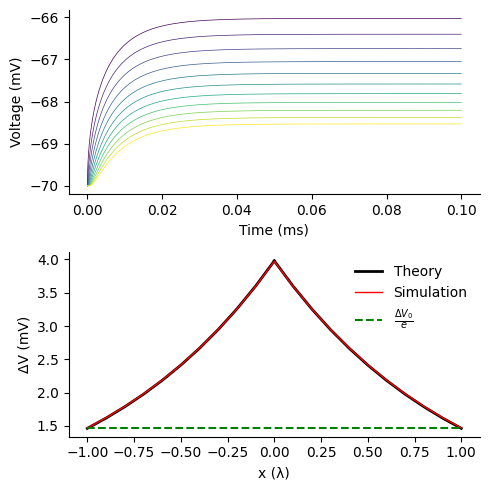

In [7]:
cmap = plt.get_cmap('viridis', Vm.shape[0]//2+1)
fig,ax = plt.subplots(2, 1, figsize=(5,5))
for i,v in enumerate(Vm[x>=0]):
    ax[0].plot(time, v, color=cmap(i), lw=0.5)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Voltage (mV)')

ax[1].plot(x[x>=0], ΔV_theory*np.exp(-x[x>=0]), 'k', lw=2, label='Theory')
ax[1].plot(-x[x>=0], ΔV_theory*np.exp(-x[x>=0]), 'k', lw=2)
ax[1].plot(x, ΔV, 'r', lw=1, label='Simulation')
ax[1].hlines(ΔV_theory*np.exp(-1), -1, 1, ls='--', color='g', label=r'$\frac{\Delta V_0}{e}$')
ax[1].set_xlabel('x (λ)')
ax[1].set_ylabel('ΔV (mV)')
ax[1].legend(loc='upper right', frameon=False)

sns.despine()
fig.tight_layout()

### Exercise
Simulate the arrival of an excitatory post-synaptic potential (EPSP) at a distance of $\lambda/2$ from one of the edges of the cable. A simple conductance-based synapse can be modeled by the following set of equations:

$
\tau_s \frac{\mathrm{d}g_s}{\mathrm{d}t} = -g_s \\
I_{syn} = g_s(E_{exc} - V_{m}).
$

The synaptic conductance is $g_s$ and the equations above model an exponentially-decaying synaptic current with time constant $\tau_s$. Whenever a presynaptic spike occurs, the value of $g_s$ is instantaneously incremented. Use $\tau_s=10\,\mathrm{ms}$, $E_{exc}=0\,\mathrm{mV}$ (excitatory synapse) and tune the value of the maximal conductance such that the EPSP at the site of injection is approximately $5\,\mathrm{mV}$.